# VRPOR for Albert Heijn Pijnacker Distribution Center

This notebook implements and solves a Vehicle Routing Problem with Order Splitting and Penalties (VRPOR). The primary focus is to model and optimize logistics operations originating from the Albert Heijn distribution center in Pijnacker, serving various AH stores and potential satellite delivery locations in the region.

The model uses a predefined set of geographic coordinates (latitude, longitude) for these locations. The core optimization model, its constraints, and objective function are based on the VRPOR formulation, aligning with standard VRP modeling practices (referred to as "Table 2 alignment" from the model's origin).

Key features:
1.  **Fixed Coordinates**: The `generate_instance_table2_final` function uses the `ah_fixed_coords` dictionary for the Albert Heijn scenario.
2.  **Parameter Scaling**: When fixed coordinates (latitude/longitude) are used, parameters like service times and deadline margins are scaled down to be proportionate to the smaller Euclidean distances typical of geographic coordinates.
3.  **Consistent Model Logic**: The `solve_vrpor_table2_final` function applies the same VRPOR mathematical model to all scenarios.
4.  **Verification**: An independent verification instance with random coordinates is maintained to test the model's core logic.

In [11]:
# Block 1: Setup, Imports, and Helper Functions
# This block imports necessary libraries (Gurobi, random, math, pandas, matplotlib, time, numpy, folium)
# and defines a helper function for Euclidean distance calculation.

import gurobipy as gp
from gurobipy import GRB
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import folium # <<< Added import for Folium

print(f"Gurobi Optimizer version: {gp.gurobi.version()}")

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

Gurobi Optimizer version: (11, 0, 0)


### Block 1 Summary
Standard library imports and a Euclidean distance helper function are set up. Gurobi version is printed.

In [12]:
# Block 2: Instance Generation Function
# This function generates the data for a VRPOR instance.
# It's modified to accept 'fixed_coords' for specific scenarios like the AH Pijnacker case.
# If fixed_coords are used (assumed lat/lon), service times and deadline margins are scaled.

def generate_instance_table2_final(num_stores, num_physical_satellites, num_products, num_orders,
                                   vehicle_capacity_V_star, penalty_pu_param, split_ps_param,
                                   seed=42, vehicle_buffer=0, fixed_coords=None):
    random.seed(seed)

    # --- SET DEFINITIONS (as per LaTeX derived from Table 2) ---
    depot_node_0 = 'D0' 

    set_S_stores = [f"S{s_idx+1}" for s_idx in range(num_stores)]
    _physical_sat_nodes_temp = [f"M{m_idx+1}" for m_idx in range(num_physical_satellites)]
    set_M_T2_sats_and_depot = [depot_node_0] + _physical_sat_nodes_temp 
    set_M_phys_physical_satellites = _physical_sat_nodes_temp
    set_N_cust_all_customers = set_S_stores + set_M_phys_physical_satellites
    set_N_all_network_nodes = list(set(set_S_stores + set_M_T2_sats_and_depot))
    set_L_arcs = [(i, j) for i in set_N_all_network_nodes for j in set_N_all_network_nodes if i != j]
    set_R_product_types = [f"P{r_idx+1}" for r_idx in range(num_products)]
    set_B_order_types = [f"B{b_idx+1}" for b_idx in range(num_orders)]

    # --- PARAMETERS ---
    param_coords = {}
    using_fixed_coords_flag = bool(fixed_coords)
    if fixed_coords:
        print("INFO: Using fixed_coords for node locations.")
        if depot_node_0 not in fixed_coords: raise ValueError(f"Depot {depot_node_0} not in fixed_coords.")
        param_coords[depot_node_0] = fixed_coords[depot_node_0]
        
        for s_node_name in set_S_stores:
            if s_node_name not in fixed_coords: raise ValueError(f"Store {s_node_name} not in fixed_coords.")
            param_coords[s_node_name] = fixed_coords[s_node_name]
        
        for m_node_name in set_M_phys_physical_satellites:
            if m_node_name not in fixed_coords: raise ValueError(f"Satellite {m_node_name} not in fixed_coords.")
            param_coords[m_node_name] = fixed_coords[m_node_name]
    else:
        print("INFO: Using random coordinates for node locations.")
        param_coords[depot_node_0] = (0, 0)
        for i_node in set_S_stores: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))
        for i_node in set_M_phys_physical_satellites: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))

    param_d_ij_dist = {}; param_t_ij_time = {}; max_travel_t_val = 0
    for i_node, j_node in set_L_arcs:
        dist_val = euclidean_distance(param_coords[i_node], param_coords[j_node])
        param_d_ij_dist[i_node, j_node] = dist_val
        param_t_ij_time[i_node, j_node] = dist_val 
        max_travel_t_val = max(max_travel_t_val, param_t_ij_time[i_node, j_node])
    for i_node in set_N_all_network_nodes : param_d_ij_dist[i_node,i_node]=0; param_t_ij_time[i_node,i_node]=0

    param_o_i_service = {node: 0 for node in set_N_all_network_nodes} 
    total_serv_t_val = 0
    for node_cust in set_N_cust_all_customers:
        if using_fixed_coords_flag: 
            param_o_i_service[node_cust] = random.uniform(0.005, 0.025) # Scaled for lat/lon
        else:
            param_o_i_service[node_cust] = random.uniform(3, 10) # Original scale
        total_serv_t_val += param_o_i_service[node_cust]

    param_V_r_volume = {r_prod: random.randint(1, 3) for r_prod in set_R_product_types}
    param_V_b_volume = {b_ord: random.randint(1, 3) for b_ord in set_B_order_types}

    param_D_i_r_S_demand = {}; total_vol_demand_S = 0
    for j_store in set_S_stores:
        for r_prod in set_R_product_types:
            demand_val = random.randint(3, 10)
            param_D_i_r_S_demand[j_store, r_prod] = demand_val
            total_vol_demand_S += param_V_r_volume[r_prod] * demand_val

    param_D_i_b_Mphys_demand = {}; total_vol_demand_M_phys = 0
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            demand_val = random.randint(3, 10)
            param_D_i_b_Mphys_demand[j_sat_phys, b_ord] = demand_val
            total_vol_demand_M_phys += param_V_b_volume[b_ord] * demand_val
    total_overall_demand_vol = total_vol_demand_S + total_vol_demand_M_phys

    param_l_i_deadline = {}
    max_deadln_val = 0
    for node_cust in set_N_cust_all_customers:
        min_req_t = param_t_ij_time.get((depot_node_0, node_cust), float('inf')) + param_o_i_service.get(node_cust, 0)
        if using_fixed_coords_flag:
            deadline_margin = random.uniform(0.05, 0.25) # Scaled for lat/lon
        else:
            deadline_margin = random.uniform(15, 50) # Original scale
        base_deadln_val = min_req_t + deadline_margin
        param_l_i_deadline[node_cust] = max(min_req_t + 0.001, base_deadln_val)
        max_deadln_val = max(max_deadln_val, param_l_i_deadline[node_cust])
    
    # Robust depot deadline and Big-M
    max_possible_route_time_estimate = (len(set_N_all_network_nodes)) * max_travel_t_val + total_serv_t_val
    param_l_i_deadline[depot_node_0] = max(max_deadln_val, 0.1) + max_possible_route_time_estimate 
    param_M_TIME_for_big_M = param_l_i_deadline[depot_node_0] * 1.5 
    if using_fixed_coords_flag and param_M_TIME_for_big_M < 50: # Ensure M is not too small for lat/lon
        param_M_TIME_for_big_M = max(50, sum(t for t in param_t_ij_time.values() if t < float('inf')) + sum(param_o_i_service.values()) + 10)


    numerator_eq1 = total_overall_demand_vol
    min_vehicles_eq1_val = math.ceil(numerator_eq1 / vehicle_capacity_V_star) if vehicle_capacity_V_star > 0 else len(set_N_cust_all_customers)
    if vehicle_capacity_V_star <= 0: print(f"Warning: vehicle_capacity_V_star is {vehicle_capacity_V_star}. Using fallback for min_vehicles_eq1_val.")
    
    num_vehicles_in_fleet = int(min_vehicles_eq1_val + vehicle_buffer)
    if num_vehicles_in_fleet == 0 and len(set_N_cust_all_customers) > 0:
        num_vehicles_in_fleet = 1
        print(f"Warning: Calculated num_vehicles_in_fleet was 0, set to 1 as there are customers.")
    set_VF_fleet = [f"K{k_idx+1}" for k_idx in range(num_vehicles_in_fleet)]

    instance_data = {
        "S_stores": set_S_stores, "M_T2_sats_and_depot": set_M_T2_sats_and_depot,
        "M_phys_satellites": set_M_phys_physical_satellites, "N_cust_customers": set_N_cust_all_customers,
        "N_all_network_nodes": set_N_all_network_nodes, "L_arcs": set_L_arcs,
        "depot_node": depot_node_0, "R_product_types": set_R_product_types,
        "B_order_types": set_B_order_types, "VF_fleet": set_VF_fleet,
        "coords": param_coords, "d_ij": param_d_ij_dist, "t_ij": param_t_ij_time,
        "o_i": param_o_i_service, "V_r": param_V_r_volume,
        "V_b": param_V_b_volume, "D_i_r": param_D_i_r_S_demand,
        "D_i_b": param_D_i_b_Mphys_demand, "l_i": param_l_i_deadline,
        "V_star": vehicle_capacity_V_star, "p_u": penalty_pu_param,
        "p_s": split_ps_param, "M_TIME_BIG": param_M_TIME_for_big_M,
        "total_demand_vol_overall": total_overall_demand_vol, "min_vehicles_eq1": min_vehicles_eq1_val,
        "vehicle_buffer": vehicle_buffer,
        "using_fixed_coords": using_fixed_coords_flag
    }
    return instance_data

### Block 2 Summary
The `generate_instance_table2_final` function defines all necessary sets (nodes, arcs, products, orders, vehicles) and parameters (coordinates, distances, times, demands, capacities, penalties, deadlines) for the VRPOR model. It supports both random coordinate generation and the use of `fixed_coords`.

In [13]:
# Block 3: VRPOR Model Building Function (Reverted to Original Style)
# This function defines and solves the VRPOR model using Gurobi,
# strictly adhering to the variable names, objective, and constraint formulations
# from the original "Table 2 alignment" code.

def solve_vrpor_table2_final(instance, time_limit=60, mip_gap=0.001, log_to_console=0):
    S = instance["S_stores"]; M_T2 = instance["M_T2_sats_and_depot"]; M_phys = instance["M_phys_satellites"]
    N_cust = instance["N_cust_customers"]; N_all = instance["N_all_network_nodes"]
    L_arcs_set = instance["L_arcs"]; depot = instance["depot_node"]
    R_set = instance["R_product_types"]; B_set = instance["B_order_types"]; VF_set = instance["VF_fleet"]
    d_ij = instance["d_ij"]; t_ij = instance["t_ij"]; o_i = instance["o_i"]
    V_r = instance["V_r"]; V_b = instance["V_b"]; D_i_r = instance["D_i_r"] 
    D_i_b = instance["D_i_b"]; l_i = instance["l_i"]; V_star = instance["V_star"] 
    p_u = instance["p_u"]; p_s = instance["p_s"]; M_BIG = instance["M_TIME_BIG"]

    model = gp.Model("VRPOR_Table2_StrictFinal_FixedCoords") # Model name updated
    model.Params.LogToConsole = log_to_console
    model.Params.TimeLimit = time_limit; model.Params.MIPGap = mip_gap; model.Params.NonConvex = 2

    # --- Decision Variables (as per LaTeX Table 2) ---
    x = model.addVars(L_arcs_set, VF_set, vtype=GRB.BINARY, name="x") 
    Q = model.addVars(S, VF_set, R_set, vtype=GRB.INTEGER, lb=0.0, name="Q") 
    Y = model.addVars(M_phys, VF_set, B_set, vtype=GRB.INTEGER, lb=0.0, name="Y") 
    t_arrival = model.addVars(N_all, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_k_j")

    # --- Auxiliary Variables for Objective ---
    t_minus_l_positive = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_minus_l_pos")
    volume_Y_jk = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="vol_Y_jk")
    total_arrivals_at_j = model.addVars(N_cust, vtype=GRB.INTEGER, lb=0.0, name="total_arrivals_j")
    extra_arrivals_at_j_positive = model.addVars(N_cust, vtype=GRB.CONTINUOUS, lb=0.0, name="extra_arrivals_j_pos")
    zero_var = model.addVar(lb=0.0, ub=0.0, name="zero_constant_for_max")

    # --- Objective Function (Eq. 2 from LaTeX) ---
    term1_travel_cost = gp.quicksum(d_ij[i_node,j_node] * x[i_node,j_node,k_veh]
                                   for (i_node,j_node) in L_arcs_set for k_veh in VF_set)

    for j_sat in M_phys: # These must be defined even if M_phys or B_set is empty for term2_penalty_cost to sum correctly
        for k_veh in VF_set:
            model.addConstr(t_minus_l_positive[j_sat, k_veh] >= t_arrival[j_sat, k_veh] - l_i[j_sat], name=f"def_t_minus_l_pos_{j_sat}_{k_veh}")
            model.addConstr(volume_Y_jk[j_sat, k_veh] == gp.quicksum(V_b[b_ord] * Y[j_sat, k_veh, b_ord]
                                                                    for b_ord in B_set if (j_sat,k_veh,b_ord) in Y), name=f"def_vol_Y_{j_sat}_{k_veh}")
    term2_penalty_cost = gp.quicksum(p_u * t_minus_l_positive[j_sat, k_veh] * volume_Y_jk[j_sat, k_veh]
                                      for j_sat in M_phys for k_veh in VF_set)

    for j_node_cust in N_cust: # These must be defined for term3_split_cost
        model.addConstr(total_arrivals_at_j[j_node_cust] == gp.quicksum(x[i_node, j_node_cust, k_veh]
                                                                    for (i_node, _j) in L_arcs_set if _j == j_node_cust 
                                                                    for k_veh in VF_set), name=f"def_total_arrivals_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= total_arrivals_at_j[j_node_cust] - 1, name=f"def_extra_arr_ge_m1_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= zero_var, name=f"def_extra_arr_ge_0_{j_node_cust}")
    term3_split_cost = p_s * gp.quicksum(extra_arrivals_at_j_positive[j_node_cust] for j_node_cust in N_cust)

    model.setObjective(term1_travel_cost + term2_penalty_cost + term3_split_cost, GRB.MINIMIZE)

    # --- Constraints (Eqs. 3-16 from LaTeX) ---
    # Eq. 3
    model.addConstr(gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set for k_veh in VF_set) <= len(VF_set), "PaperEq3_TotalDepartures")

    # Eq. 4
    for k_veh in VF_set:
        sum_out_depot = gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set)
        sum_in_depot  = gp.quicksum(x[i_node_cust,depot,k_veh] for i_node_cust in N_cust if (i_node_cust,depot) in L_arcs_set)
        model.addConstr(sum_out_depot == sum_in_depot, f"PaperEq4_ReturnToDepot_{k_veh}")
        model.addConstr(sum_out_depot <= 1, f"PaperEq4_DepartDepotOnce_{k_veh}")

    # Eq. 5
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            model.addConstr(gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust) <= 1, f"PaperEq5_VisitCustOncePerVeh_{k_veh}_{j_node_cust}")

    # Eq. 6
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            inflow_j = gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust)
            outflow_j = gp.quicksum(x[j_node_cust,l_node,k_veh] for l_node in N_all if (j_node_cust,l_node) in L_arcs_set and l_node != j_node_cust)
            model.addConstr(inflow_j - outflow_j == 0, f"PaperEq6_FlowConservation_{k_veh}_{j_node_cust}")

    # Eq. 7
    for j_store in S:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_store, k_veh] for i_node in N_all if (i_node, j_store) in L_arcs_set and i_node != j_store)
            for r_prod in R_set:
                if (j_store, r_prod) in D_i_r:
                     model.addConstr(Q[j_store, k_veh, r_prod] <= D_i_r[j_store, r_prod] * vehicle_visits_j, f"PaperEq7_LinkQtoX_{j_store}_{k_veh}_{r_prod}")

    # Eq. 8
    for j_sat in M_phys:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_sat, k_veh] for i_node in N_all if (i_node, j_sat) in L_arcs_set and i_node != j_sat)
            for b_ord in B_set:
                 if (j_sat, b_ord) in D_i_b:
                    model.addConstr(Y[j_sat, k_veh, b_ord] <= D_i_b[j_sat, b_ord] * vehicle_visits_j, f"PaperEq8_LinkYtoX_{j_sat}_{k_veh}_{b_ord}")

    # Eq. 9
    for k_veh in VF_set:
        volume_products_Q = gp.quicksum(V_r[r_prod] * Q[j_store,k_veh,r_prod] for j_store in S for r_prod in R_set if (j_store,k_veh,r_prod) in Q)
        volume_orders_Y = gp.quicksum(V_b[b_ord] * Y[j_sat,k_veh,b_ord] for j_sat in M_phys for b_ord in B_set if (j_sat,k_veh,b_ord) in Y)
        model.addConstr(volume_products_Q + volume_orders_Y <= V_star, f"PaperEq9_VehicleCapacity_{k_veh}")

    # Eq. 10
    for j_store in S:
        for r_prod in R_set:
            if (j_store, r_prod) in D_i_r:
                model.addConstr(gp.quicksum(Q[j_store,k_veh,r_prod] for k_veh in VF_set if (j_store,k_veh,r_prod) in Q) == D_i_r[j_store,r_prod], f"PaperEq10_DemandSat_S_{j_store}_{r_prod}")

    # Eq. 11
    for j_sat in M_phys:
        for b_ord in B_set:
             if (j_sat, b_ord) in D_i_b:
                model.addConstr(gp.quicksum(Y[j_sat,k_veh,b_ord] for k_veh in VF_set if (j_sat,k_veh,b_ord) in Y) == D_i_b[j_sat,b_ord], f"PaperEq11_DemandSat_Mphys_{j_sat}_{b_ord}")

    # Eq. 12
    model.addConstrs((t_arrival[depot,k_veh] == 0 for k_veh in VF_set), name="TimeAtDepotIsZero_Eq12_base")
    for k_veh in VF_set:
        for j_node_cust in N_cust: 
            for i_node in N_all: 
                if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust :
                    model.addConstr(t_arrival[j_node_cust,k_veh] >= t_arrival[i_node,k_veh] + o_i.get(i_node,0) + t_ij.get((i_node,j_node_cust),0) - M_BIG*(1-x[i_node,j_node_cust,k_veh]), f"PaperEq12_TimeProp_{k_veh}_{i_node}_{j_node_cust}")

    # Eq. 13
    for k_veh in VF_set:
        for j_store in S:
            is_visited_by_k = gp.quicksum(x[i_node,j_store,k_veh] for i_node in N_all if (i_node,j_store) in L_arcs_set and i_node != j_store)
            model.addConstr(t_arrival[j_store,k_veh] <= l_i[j_store] + M_BIG*(1-is_visited_by_k), f"PaperEq13_HardTW_S_{k_veh}_{j_store}")
    
    # Eq. 14 (x binary), Eq. 15 (Y integer), Eq. 16 (Q integer) are handled by var definitions.

    # Symmetry Breaking
    for k_idx in range(len(VF_set)-1):
        k_curr, k_next = VF_set[k_idx], VF_set[k_idx+1]
        sum_departs_curr = gp.quicksum(x[depot, jc, k_curr] for jc in N_cust if (depot, jc) in L_arcs_set)
        sum_departs_next = gp.quicksum(x[depot, jc, k_next] for jc in N_cust if (depot, jc) in L_arcs_set)
        model.addConstr(sum_departs_next <= sum_departs_curr, f"SymmetryBreaking_VehOrder_{k_curr}_{k_next}")

    start_time=time.time();model.optimize();end_time=time.time();solve_duration=end_time-start_time
    results={"instance":instance,"model":model,"status_code":model.status,"solve_time":solve_duration,"status_message":{GRB.OPTIMAL:"Optimal",GRB.TIME_LIMIT:"Time Limit Reached",GRB.INTERRUPTED:"Interrupted",GRB.INFEASIBLE:"Infeasible",GRB.UNBOUNDED:"Unbounded",GRB.INF_OR_UNBD:"Infeasible or Unbounded"}.get(model.status,f"Unknown Status ({model.status})")}
    if model.status in [GRB.OPTIMAL,GRB.TIME_LIMIT,GRB.INTERRUPTED] and model.SolCount>0:
        results.update({"objective_value":model.ObjVal,"runtime":model.Runtime,"mip_gap":model.MIPGap,"node_count":model.NodeCount})
        
        sol_x_val={ k_sol_tuple : k_sol_var.X for k_sol_tuple,k_sol_var in x.items() if k_sol_var.X > 0.5 }
        sol_Q_val={k_sol:v.X for k_sol,v in Q.items() if v.X>0.001}
        sol_Y_val={k_sol:v.X for k_sol,v in Y.items() if v.X>0.001}
        sol_t_val={k_sol:v.X for k_sol,v in t_arrival.items()}
        
        sol_late_plus_val = {}
        if hasattr(t_minus_l_positive, 'items'): 
            sol_late_plus_val={k_s:v.X for k_s,v in t_minus_l_positive.items() if v.X > 1e-6}
        
        sol_extra_arrivals_val = {}
        if hasattr(extra_arrivals_at_j_positive, 'items'):
             sol_extra_arrivals_val={k_s:v.X for k_s,v in extra_arrivals_at_j_positive.items() if v.X > 0.5} 

        sol_volY_kj_val = {}
        if hasattr(volume_Y_jk, 'items'):
            sol_volY_kj_val={k_s:v.X for k_s,v in volume_Y_jk.items() if v.X > 1e-4}

        results["solution"]={"x":sol_x_val,"Q":sol_Q_val,"Y":sol_Y_val,"t_arrival":sol_t_val,
                             "lateness_positive_part":sol_late_plus_val,
                             "split_extra_visits_image":sol_extra_arrivals_val,
                             "total_volume_Y_jk_for_penalty":sol_volY_kj_val}

        obj_T_calc=sum(d_ij[i,j]*x_val for (i,j,k),x_val in sol_x_val.items() if (i,j) in d_ij)
        obj_P_calc=sum(p_u*sol_late_plus_val.get((jm,kv),0)*sol_volY_kj_val.get((jm,kv),0) for jm in M_phys for kv in VF_set)
        obj_S_calc=sum(p_s*val for jc,val in sol_extra_arrivals_val.items())
        results["objective_components"]={"travel":obj_T_calc,"penalty":obj_P_calc,"split":obj_S_calc,"calculated_total":obj_T_calc+obj_P_calc+obj_S_calc}

        routes_found={}; cust_served_set=set()
        for k_v_rt in VF_set:
            departs_d = any(sol_x_val.get(((depot,jc,k_v_rt)),0)>0.5 for jc in N_cust if (depot,jc) in L_arcs_set)
            if departs_d:
                rt_k_list=[depot];curr_node_rt=depot;visited_nodes_rt={depot}
                for _ in range(len(N_all)+2): 
                    next_node_sel=None
                    for i_arc_rt, j_arc_rt in L_arcs_set:
                        if i_arc_rt == curr_node_rt and sol_x_val.get(((i_arc_rt,j_arc_rt,k_v_rt)),0)>0.5:
                            if j_arc_rt not in visited_nodes_rt or (j_arc_rt == depot and len(rt_k_list) > 1):
                                next_node_sel=j_arc_rt; break
                    if not next_node_sel: 
                        if curr_node_rt != depot and (curr_node_rt, depot) in L_arcs_set and sol_x_val.get(((curr_node_rt,depot,k_v_rt)),0)>0.5:
                             if depot not in visited_nodes_rt or len(rt_k_list) > 1 : 
                                rt_k_list.append(depot)
                        break
                    rt_k_list.append(next_node_sel)
                    if next_node_sel != depot : visited_nodes_rt.add(next_node_sel) 
                    if next_node_sel in N_cust:cust_served_set.add(next_node_sel)
                    curr_node_rt=next_node_sel
                    if curr_node_rt==depot and len(rt_k_list)>1 :break 
                
                if len(rt_k_list)>2 and rt_k_list[0]==depot and rt_k_list[-1]==depot:
                    routes_found[k_v_rt]=rt_k_list
                elif len(rt_k_list)>1 and rt_k_list[0]==depot: 
                    final_node = rt_k_list[-1]
                    if final_node != depot and (final_node, depot) in L_arcs_set and sol_x_val.get(((final_node, depot, k_v_rt)), 0) > 0.5:
                        rt_k_list.append(depot)
                        if rt_k_list[0] == depot and rt_k_list[-1] == depot:
                             routes_found[k_v_rt]=rt_k_list
                        else: print(f"Warning: Route {k_v_rt} seems incomplete after trying to close: {rt_k_list}")
                    elif final_node != depot:
                        print(f"Warning: Route {k_v_rt} is incomplete or open: {rt_k_list}")
        results["routes"]=routes_found;results["nodes_served"]=len(cust_served_set)
    else:results.update({"objective_value":None,"runtime":model.Runtime,"mip_gap":None,"node_count":model.NodeCount if hasattr(model,'NodeCount') else None,"solution":None,"routes":None,"nodes_served":0,"objective_components":None})
    return results

### Block 3 Summary
The `solve_vrpor_table2_final` function constructs and solves the VRPOR mathematical model. It defines decision variables (routes, quantities delivered), auxiliary variables for the objective, the objective function (minimizing travel, lateness penalties, and split delivery costs), and all constraints (vehicle capacity, demand satisfaction, time windows, flow conservation, etc.) as per the specified "Table 2" formulation.

In [14]:
# Block 4: Results Printing and Plotting Functions
# These functions are used to display the optimization results in a readable format
# and to visualize the routes and cost breakdown.
# A new function `plot_solution_routes_on_map` is added for HTML map visualization using Folium.

def print_results_summary(results):
    print("\n--- Optimization Summary ---")
    print(f"Status: {results.get('status_message', 'N/A')} (Code: {results.get('status_code', 'N/A')})")
    obj_val = results.get("objective_value")
    if obj_val is not None:
        precision = ".4f" if results.get('instance', {}).get('using_fixed_coords', False) else ".2f"
        
        print(f"Objective Value: {obj_val:{precision}}")
        obj_comp = results.get("objective_components")
        if obj_comp: 
            print(f"  Components: Travel={obj_comp['travel']:{precision}}, Penalty={obj_comp['penalty']:{precision}}, Split={obj_comp['split']:.2f} (Calc Sum: {obj_comp['calculated_total']:{precision}})")
        else: print("  Objective components not calculated.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"MIP Gap: {results.get('mip_gap','N/A'):.4f}" if results.get('mip_gap') is not None else "MIP Gap: N/A")
        print(f"Nodes Explored: {results.get('node_count','N/A')}")
        
        num_total_cust = 0
        if results.get('instance') and results['instance'].get('N_cust_customers'):
            num_total_cust = len(results['instance']['N_cust_customers'])
        print(f"Nodes Served: {results.get('nodes_served','N/A')} / {num_total_cust}")
            
        routes = results.get("routes"); sol = results.get("solution")
        if routes: print(f"\nRoutes Found ({len(routes)}):"); [print(f"  {k}: {' -> '.join(route)}") for k,route in routes.items()]
        else: print("\nNo valid routes extracted.")
        if sol:
             split_visits_img = sol.get("split_extra_visits_image")
             lateness_pos_part_vals = sol.get("lateness_positive_part")
             if split_visits_img and any(v > 0.5 for v in split_visits_img.values()): 
                 print("\nSplit Deliveries (Extra Visits > 0):"); [print(f"  Node {j}: {int(round(extra))} extra visit(s)") for j, extra in split_visits_img.items() if extra > 0.5]
             
             lateness_label = "time units late"
             if results.get('instance') and results['instance'].get('using_fixed_coords', False):
                 lateness_label = "(pseudo) time units late (based on degree distances)"
             if lateness_pos_part_vals and any(v > 1e-6 for v in lateness_pos_part_vals.values()):
                 print(f"\nLate Deliveries at Satellites (Lateness > 0):"); [print(f"  Node {jk[0]} by Veh {jk[1]}: {val:{precision}} {lateness_label}") for jk, val in lateness_pos_part_vals.items() if val > 1e-6]
    else:
        print("No feasible solution found or optimization failed."); print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s"); print(f"Nodes Explored: {results.get('node_count','N/A')}")
    print("--------------------------\n")

def plot_solution_routes(results): # Matplotlib plot
    instance = results.get("instance"); routes = results.get("routes")
    if not instance or not routes or not instance.get("coords"): 
        print("Cannot plot (matplotlib): Missing instance, routes, or coordinates."); return
        
    coords = instance["coords"]; depot = instance["depot_node"]
    S_nodes = instance["S_stores"]; M_nodes = instance["M_phys_satellites"]
    is_fixed_coords = instance.get("using_fixed_coords", False)

    plt.figure(figsize=(12,10))
    x_idx, y_idx = (1, 0) if is_fixed_coords else (0, 1) 
    xlabel, ylabel = ("Longitude", "Latitude") if is_fixed_coords else ("X-coord", "Y-coord")
    text_offset = 0.001 if is_fixed_coords else 0.8

    if depot in coords:
        plt.scatter(coords[depot][x_idx], coords[depot][y_idx], c='black', marker='s', s=150, label=f'Depot ({depot})', zorder=5)
    
    if S_nodes: 
        s_coords_to_plot = [(coords[s][x_idx], coords[s][y_idx]) for s in S_nodes if s in coords]
        if s_coords_to_plot:
            plt.scatter(*zip(*s_coords_to_plot), c='blue', marker='o', s=80, label='Stores (S)', zorder=5)
            
    if M_nodes: 
        m_coords_to_plot = [(coords[m][x_idx], coords[m][y_idx]) for m in M_nodes if m in coords]
        if m_coords_to_plot:
            plt.scatter(*zip(*m_coords_to_plot), c='red', marker='^', s=80, label='Satellites (M_phys)', zorder=5)

    for node_id, node_coords_tuple in coords.items():
        plt.text(node_coords_tuple[x_idx], node_coords_tuple[y_idx] + text_offset, node_id, fontsize=9, ha='center')
    
    num_r = len(routes); colors = plt.cm.viridis(np.linspace(0,1,max(1,num_r))) if num_r >0 else ['gray']
    veh_idx = 0
    for k,route in routes.items():
        route_coords_list = []
        for node_in_route in route:
            if node_in_route in coords: 
                route_coords_list.append((coords[node_in_route][x_idx], coords[node_in_route][y_idx]))
            else: print(f"Warning: Node {node_in_route} in route for vehicle {k} not in coords dict."); return 
        if not route_coords_list: continue
        
        route_coords_arr = np.array(route_coords_list)
        plt.plot(route_coords_arr[:,0], route_coords_arr[:,1], linestyle='-', marker='.', color=colors[min(veh_idx, len(colors)-1)], label=f'Veh {k}', lw=1.5, ms=5)
        veh_idx+=1
        
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title("Vehicle Routes (Matplotlib)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=min(5,num_r+3 if num_r else 1))
    plt.grid(True,ls='--',alpha=0.6)
    if not is_fixed_coords: 
        plt.axis('equal') 
    plt.tight_layout(rect=[0,0.05,1,1]); plt.show()

def plot_cost_breakdown(results):
    obj_comp = results.get("objective_components"); obj_val = results.get("objective_value")
    if not obj_comp or obj_val is None or abs(obj_val) <=1e-6 : 
        print("Cannot plot cost: Missing components or zero/neg objective."); return
    
    precision = ".4f" if results.get('instance', {}).get('using_fixed_coords', False) else ".2f"
    labels = ['Travel','Penalty (Lateness)','Split Cost']
    sizes = [obj_comp.get('travel',0), obj_comp.get('penalty',0), obj_comp.get('split',0)]
    
    labels_f = [l for i,l in enumerate(labels) if abs(sizes[i])>1e-6]; 
    sizes_f = [s for s in sizes if abs(s)>1e-6]
    if not sizes_f: print("Cost breakdown: All components are zero/negligible."); return
    
    fig,ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts = ax.pie(sizes_f, labels=labels_f, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax.axis('equal'); plt.title(f'Objective Cost Breakdown (Total: {obj_val:{precision}})')
    centre_circle=plt.Circle((0,0),0.70,fc='white'); fig.gca().add_artist(centre_circle)
    plt.setp(autotexts, size=10, weight="bold", color="white")
    plt.setp(texts, size=12)
    plt.tight_layout(); plt.show()

# --- NEW FUNCTION FOR FOLIUM MAP ---
def plot_solution_routes_on_map(results, map_filename="vrp_routes_map.html"):
    instance = results.get("instance")
    routes_dict = results.get("routes")

    if not instance or not routes_dict or not instance.get("coords"):
        print("Cannot plot Folium map: Missing instance data, routes, or coordinates.")
        return
    
    if not instance.get("using_fixed_coords", False):
        print("Folium map is most meaningful for geographic (fixed) coordinates. Skipping for random coordinates.")
        return

    coords = instance["coords"] 
    depot_node = instance["depot_node"]
    S_nodes = instance["S_stores"]
    M_nodes = instance["M_phys_satellites"]
    deadlines = instance.get("l_i", {})

    if depot_node not in coords:
        print(f"Depot node '{depot_node}' coordinates not found. Cannot create map.")
        return

    # Folium expects (latitude, longitude)
    map_center = coords[depot_node] 
    m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")

    # Depot Marker
    folium.Marker(
        location=coords[depot_node],
        popup=f"Depot: {depot_node}",
        tooltip=f"Depot: {depot_node}",
        icon=folium.Icon(color="black", icon="industry", prefix="fa")
    ).add_to(m)

    # Store Markers
    for s_node in S_nodes:
        if s_node in coords:
            popup_text = f"Store: {s_node}<br>Deadline: {deadlines.get(s_node, 'N/A'):.2f}"
            folium.Marker(
                location=coords[s_node],
                popup=popup_text,
                tooltip=f"Store: {s_node}",
                icon=folium.Icon(color="blue", icon="shopping-cart", prefix="fa")
            ).add_to(m)

    # Satellite Markers
    for m_node in M_nodes:
        if m_node in coords:
            popup_text = f"Satellite: {m_node}<br>Deadline: {deadlines.get(m_node, 'N/A'):.2f}"
            folium.Marker(
                location=coords[m_node],
                popup=popup_text,
                tooltip=f"Satellite: {m_node}",
                icon=folium.Icon(color="red", icon="home", prefix="fa") # Changed icon for satellites
            ).add_to(m)
    
    num_routes = len(routes_dict)
    if num_routes > 0:
        # Generate distinct colors for routes
        route_colors_mpl = plt.cm.get_cmap('gist_rainbow', num_routes) # Using a vibrant colormap
        colors_hex = [plt.matplotlib.colors.to_hex(route_colors_mpl(i)) for i in range(num_routes)]
    else:
        colors_hex = ['gray'] # Fallback color if no routes
    
    route_idx = 0
    for vehicle, route_nodes in routes_dict.items():
        route_lat_lon = []
        for node_id in route_nodes:
            if node_id in coords:
                route_lat_lon.append(coords[node_id]) # Folium expects (lat,lon)
            else:
                print(f"Warning: Node {node_id} in route for vehicle {vehicle} not in coords dict.")
                continue # Skip this node if not found
        
        if len(route_lat_lon) > 1: # Need at least two points to draw a line
            color_to_use = colors_hex[route_idx % len(colors_hex)] 
            folium.PolyLine(
                locations=route_lat_lon,
                color=color_to_use,
                weight=2.5,
                opacity=0.8,
                tooltip=f"Route: Vehicle {vehicle}"
            ).add_to(m)
            # Optional: Add small circle markers for each stop on the route
            # for point_idx, point_coords in enumerate(route_lat_lon):
            #      folium.CircleMarker(location=point_coords, radius=3, color=color_to_use, fill=True, 
            #                          fill_color=color_to_use, fill_opacity=0.7, 
            #                          tooltip=f"Veh {vehicle}: {route_nodes[point_idx]} (Stop {point_idx+1})").add_to(m)
            route_idx += 1

    try:
        m.save(map_filename)
        print(f"Folium map saved as {map_filename}. Open this file in a web browser to view.")
    except Exception as e:
        print(f"Error saving Folium map: {e}")

### Block 4 Summary
This block contains functions for presenting results: `print_results_summary` (text), `plot_solution_routes` (Matplotlib scatter plot), `plot_cost_breakdown` (pie chart), and the newly added `plot_solution_routes_on_map` (Folium HTML map). The Folium map is best suited for scenarios using geographic coordinates.

--- Generating AH Pijnacker Scenario Instance ---
INFO: Using fixed_coords for node locations.
AH Instance: 15 Stores, 6 Satellites (21 customers).
Total demand volume: 448.00.
Vehicle fleet: 6 (Capacity: 100). Min. vehicles (Eq1): 5
M_TIME_BIG used: 51.0686

--- Solving AH Pijnacker Scenario ---
Set parameter TimeLimit to value 180
Set parameter MIPGap to value 0.05
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3405 rows, 3235 columns and 26655 nonzeros
Model fingerprint: 0xfff91ed0
Model has 36 quadratic objective terms
Variable types: 226 continuous, 3009 integer (2772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [4e-04, 1e+02]
  QObjective range [4e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01

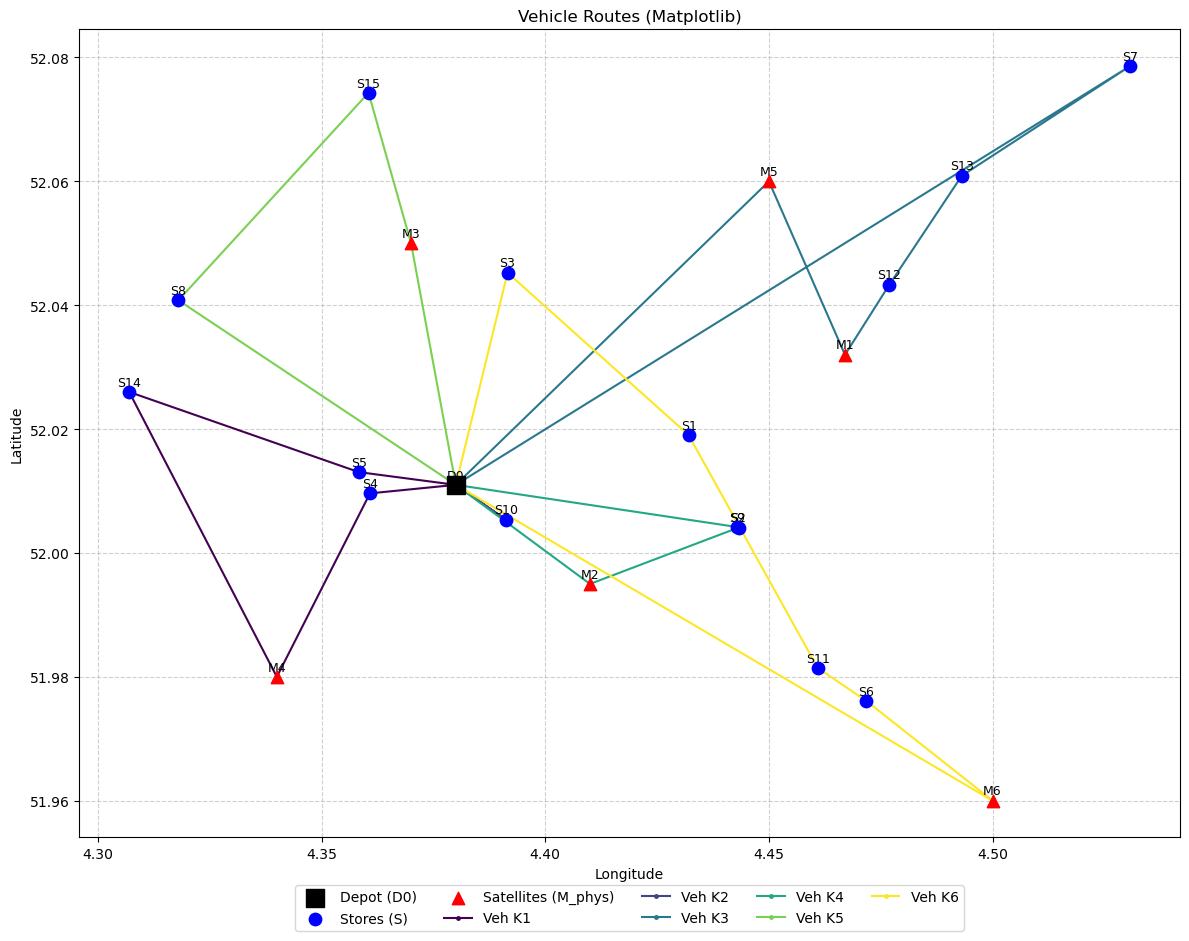

/var/folders/0x/glkrv8553s162_k_fy8b476c0000gn/T/ipykernel_12497/3316235106.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  route_colors_mpl = plt.cm.get_cmap('gist_rainbow', num_routes) # Using a vibrant colormap


Folium map saved as ah_pijnacker_routes_map.html. Open this file in a web browser to view.


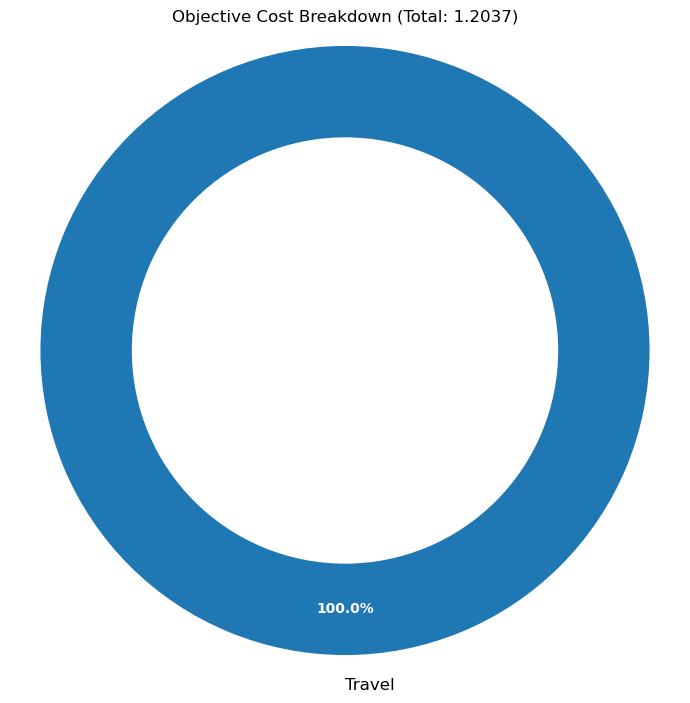

In [17]:
# Block 5: Albert Heijn Pijnacker Scenario Setup and Execution
# This block defines the fixed coordinates for the Albert Heijn Pijnacker DC,
# stores, and satellite locations. It then sets up and runs the VRPOR model
# for this specific scenario.

ah_fixed_coords = {
    'D0': (52.0110, 4.3800),       # AH DC Pijnacker
    # Stores (S): A larger subset of 15 stores
    'S1': (52.019028, 4.432054),   # AH Ackershof, Pijnacker
    'S2': (52.0041027, 4.4432056), # AH Keijzershof, Pijnacker
    'S3': (52.0452529, 4.3915828), # AH Nootdorp (Lange Baan 6)
    'S4': (52.0096251, 4.3608201), # AH Delft Brabantse Turfmarkt
    'S5': (52.0130556, 4.3583333), # AH Delft Choorstraat (Buitenhof)
    'S6': (51.9761, 4.4718),       # AH Berkel en Rodenrijs Westerplein
    'S7': (52.0786, 4.5307),       # AH Zoetermeer Oosterheem
    'S8': (52.0408, 4.3180),       # AH Ypenburg (Laan van Hoornwijck 160)
    'S9': (52.0042, 4.442798),     # AH Hoefbladplein, Pijnacker
    'S10': (52.0053782, 4.3912036),# AH Gouden Rijderplein 1, Delfgauw
    'S11': (51.9814368, 4.4609031),# AH Berkel en Rodenrijs Rozenoord 2
    'S12': (52.0433143, 4.4769132),# AH Zoetermeer Samanthagang 64
    'S13': (52.0609, 4.4931),      # AH Zoetermeer Quirinegang (Meerzicht)
    'S14': (52.0260, 4.3070),      # AH Rijswijk, In de Bogaard
    'S15': (52.0743, 4.3605),      # AH Voorburg, Koningin Julianaplein
    # S16, S17 etc. would be here if we needed more than 15 from a larger list

    # Satellites (M): A subset of 6 satellites
    'M1': (52.0320, 4.4670),      # Nootdorp - Veenweg area
    'M2': (51.9950, 4.4100),      # Delft - Wippolder area
    'M3': (52.0500, 4.3700),      # Den Haag - Leidschenveen
    'M4': (51.9800, 4.3400),      # Delft - Tanthof
    'M5': (52.0600, 4.4500),      # Zoetermeer - Rokkeveen
    'M6': (51.9600, 4.5000),      # Berkel - Rodenrijs Westpolder
    # M7, M8 etc. would be here if we needed more than 6
}

# Parameters for the AH scenario.
# num_stores and num_physical_satellites will be set based on the desired count
# using the available fixed_coords.
num_ah_stores = 15       # We will use S1 through S15 from ah_fixed_coords
num_ah_satellites = 6    # We will use M1 through M6 from ah_fixed_coords

# Using ONLY the allowed parameters for ah_scenario_params as per your constraint
ah_scenario_params = {
    "num_stores": num_ah_stores,
    "num_physical_satellites": num_ah_satellites,
    "num_products": 2,
    "num_orders": 1,
    "vehicle_capacity_V_star": 100,
    "penalty_pu_param": 20.0,
    "split_ps_param": 100.0,
    "seed": 123, # Keeping seed as per your original constraint
    "vehicle_buffer": 1,
    "fixed_coords": ah_fixed_coords # This will be used by generate_instance to pick the first N stores/satellites
}

print("--- Generating AH Pijnacker Scenario Instance ---")
ah_instance = generate_instance_table2_final(**ah_scenario_params)

print(f"AH Instance: {len(ah_instance['S_stores'])} Stores, {len(ah_instance['M_phys_satellites'])} Satellites ({len(ah_instance['N_cust_customers'])} customers).")
print(f"Total demand volume: {ah_instance['total_demand_vol_overall']:.2f}.")
print(f"Vehicle fleet: {len(ah_instance['VF_fleet'])} (Capacity: {ah_instance['V_star']}). Min. vehicles (Eq1): {ah_instance['min_vehicles_eq1']}")
print(f"M_TIME_BIG used: {ah_instance['M_TIME_BIG']:.4f}")


print("\n--- Solving AH Pijnacker Scenario ---")
ah_results = solve_vrpor_table2_final(ah_instance, time_limit=180, mip_gap=0.05, log_to_console=1) 
print_results_summary(ah_results)

print("\n--- Visualizing AH Pijnacker Scenario Results ---")
if ah_results.get("routes"):
    plot_solution_routes(ah_results) # Original matplotlib plot
    plot_solution_routes_on_map(ah_results, map_filename="ah_pijnacker_routes_map.html") # <<< Call Folium map
if ah_results.get("objective_components"):
    plot_cost_breakdown(ah_results)

### Block 5 Summary
This block sets up and runs the VRPOR model for the Albert Heijn Pijnacker distribution center. It uses predefined geographic coordinates. The instance is generated, the model is solved, and the results are printed and plotted.

In [ ]:
# Block 6: Verification Instance Setup and Execution (Original)
# This block maintains the original verification instance from the initial code.
# It uses random coordinates and specific manual parameter overrides to test
# the model logic under a controlled, well-understood setup, independent of the
# AH scenario's lat/lon scale.

print("\n\n--- Verification Instance Generation & Setup (Strict Table 2 Alignment - Original) ---")
verify_params_final = {"num_stores":1,"num_physical_satellites":1,"num_products":1,"num_orders":1,
                       "vehicle_capacity_V_star":100,"penalty_pu_param":10.0,"split_ps_param":1000.0,
                       "seed":1, "vehicle_buffer":1, "fixed_coords": None} # Ensure fixed_coords is None

verify_instance_original = generate_instance_table2_final(**verify_params_final)
print(f"Verification: Min vehicles by Eq1: {verify_instance_original['min_vehicles_eq1']}, Actual |VF|: {len(verify_instance_original['VF_fleet'])}")

# Manual overrides for the verification instance as in the original code
s_v = verify_instance_original["S_stores"][0]; m_v = verify_instance_original["M_phys_satellites"][0]
p_v = verify_instance_original["R_product_types"][0]; o_v = verify_instance_original["B_order_types"][0]
d_v_depot = verify_instance_original["depot_node"]

verify_instance_original["D_i_r"] = {(s_v,p_v):10}; verify_instance_original["D_i_b"] = {(m_v,o_v):8}
verify_instance_original["V_r"] = {p_v:5}; verify_instance_original["V_b"] = {o_v:6} # Total demand: 10*5 + 8*6 = 50 + 48 = 98. V_star=100. Min_veh=1. VF_fleet size = 1+1 = 2.
verify_instance_original["coords"][s_v]=(3,4); verify_instance_original["coords"][m_v]=(-6,8) # d(0,S1)=5, d(0,M1)=10
verify_instance_original["o_i"][s_v]=2; verify_instance_original["o_i"][m_v]=3
verify_instance_original["l_i"][s_v]=15; verify_instance_original["l_i"][m_v]=30 

nodes_v_all = verify_instance_original["N_all_network_nodes"]; d_v_new={}; t_v_new={}
max_t_val_v = 0
for i_n_v in nodes_v_all:
    for j_n_v in nodes_v_all:
        d_val=euclidean_distance(verify_instance_original["coords"][i_n_v],verify_instance_original["coords"][j_n_v]) if i_n_v!=j_n_v else 0
        d_v_new[i_n_v,j_n_v]=d_val; t_v_new[i_n_v,j_n_v]=d_val
        if i_n_v != j_n_v: max_t_val_v = max(max_t_val_v, d_val)

verify_instance_original["d_ij"]=d_v_new; verify_instance_original["t_ij"]=t_v_new

# Recalculate depot deadline and M_TIME_BIG for verification instance after coord/service time overrides
max_deadln_val_v = 0
total_serv_t_val_v = 0
for node_cust_v in verify_instance_original["N_cust_customers"]:
    min_req_t_v = verify_instance_original["t_ij"].get((d_v_depot, node_cust_v), float('inf')) + verify_instance_original["o_i"].get(node_cust_v, 0)
    # Use original deadline margin logic for verification
    base_deadln_val_v = min_req_t_v + random.uniform(15, 50) # Original range
    verify_instance_original["l_i"][node_cust_v] = max(min_req_t_v + 0.1, base_deadln_val_v)
    max_deadln_val_v = max(max_deadln_val_v, verify_instance_original["l_i"][node_cust_v])
    total_serv_t_val_v += verify_instance_original["o_i"][node_cust_v]

max_possible_route_time_estimate_v = (len(verify_instance_original["N_all_network_nodes"])) * max_t_val_v + total_serv_t_val_v
verify_instance_original["l_i"][d_v_depot] = max(max_deadln_val_v, 0.1) + max_possible_route_time_estimate_v
verify_instance_original["M_TIME_BIG"] = verify_instance_original["l_i"][d_v_depot] * 1.5

verify_instance_original["L_arcs"] = [(i, j) for i in verify_instance_original["N_all_network_nodes"] for j in verify_instance_original["N_all_network_nodes"] if i != j]
print("Verification instance setup complete (using original random coord scale logic and overrides).")
print(f"Verification M_TIME_BIG: {verify_instance_original['M_TIME_BIG']:.2f}")


print("\n--- Solving Original Verification Instance ---")
# Use moderate time limit for verification
verify_results_original = solve_vrpor_table2_final(verify_instance_original, time_limit=60, mip_gap=0.001, log_to_console=1)
print_results_summary(verify_results_original)

print("\n--- Visualizing Original Verification Instance Results ---")
if verify_results_original.get("routes"):
    plot_solution_routes(verify_results_original)
if verify_results_original.get("objective_components"):
    plot_cost_breakdown(verify_results_original)

print("\nScript fully completed.")

### Block 6 Summary
This block reproduces the original verification instance. It uses random coordinates (not the AH fixed ones) and applies specific manual overrides to demands, volumes, coordinates, service times, and deadlines. This helps ensure the model behaves as expected on a known small-scale problem, independently of the geographic scaling used in the AH scenario. The instance is generated, solved, and results are displayed.